## Score Alignment
---

Example to produce score/prediction alignment based on cumulative bad rate.

In [1]:
import sys, os, json
sys.path.insert(1, "../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ml4risk.model_selection import score_alignment as sa

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

### Get Data

In [2]:
test_df = pd.read_parquet(os.path.join("s3://sofi-data-science/Risk_DS/rdsutils_data/", "customer_pred_score_rg.parquet"))

In [3]:
test_df.head()

,pred_old,score_old,pred_new,score_new,risk_group_old,risk_group_new,target
12703,0.001044,420.468318,0.014136,501.152627,RG1,RG2,False
17074,0.786693,672.159133,0.965468,734.573168,RG5,RG5,True
19216,0.853470,686.239774,0.964090,733.324311,RG5,RG5,True
31532,0.907194,702.193300,0.973137,742.556065,RG5,RG5,True
37589,0.001542,432.498815,0.082503,557.724063,RG1,RG5,False


### Produce Score Alignment based on bad rate

In [4]:
src_pred = "pred_new"
tgt_pred = "pred_old"
target_col = "target"

br_tbl = sa.get_score_alignment_table(test_df, src_pred, tgt_pred, target_col,
                                   br_precision = 3, pred_precision = 3)
test_df[src_pred + "_rescaled"] = sa.get_aligned_score(test_df, br_tbl, src_pred, tgt_pred,
                                                    pred_precision=3)

source column:  pred_new
target columns:  pred_old


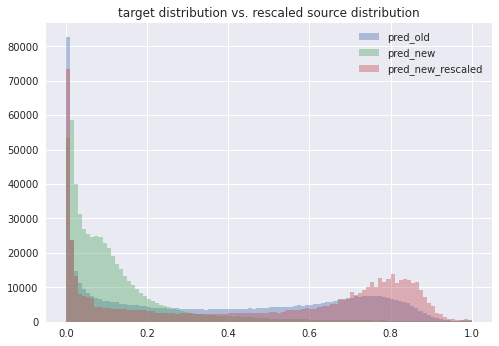

In [5]:
test_df[tgt_pred].hist(bins=100, alpha=0.4, label=tgt_pred)
test_df[src_pred].hist(bins=100, alpha=0.4, label=src_pred)
test_df[src_pred+"_rescaled"].hist(bins=100, alpha=0.4, label=src_pred+"_rescaled")
plt.title("target distribution vs. rescaled source distribution")
plt.legend()

In [6]:
def scale_scores(predictions):
    """
    Convert probability to score.
    """
    try:
        assert (
            (predictions >= 0) & (predictions <= 1)
        ).all(), "probability must be in range [0,1]"
    except AssertionError:
        raise

    # Formula parameters
    ALPHA = 631.9455383610933
    BETA = 30.812519272450654

    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(
        np.maximum(np.log(predictions / (1 - predictions)) * BETA + ALPHA, MINIMUM),
        MAXIMUM,
    )

    return score

def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

In [7]:
print("rescaled prediction column: ", src_pred+"_rescaled")
test_df["score_rescaled_new"] = scale_scores(test_df[src_pred+"_rescaled"])
test_df["risk_group_rescaled_new"] = get_risk_groups(test_df["score_rescaled_new"])

rescaled prediction column:  pred_new_rescaled


(570248, 10)

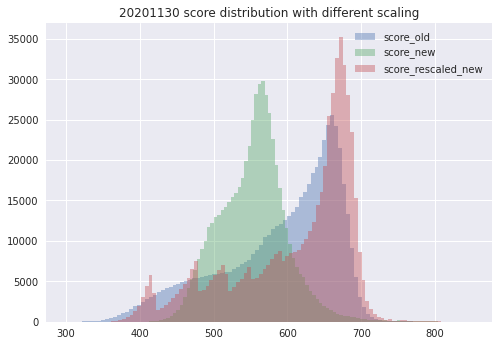

In [8]:
df_ = test_df

display(df_.shape)

score_col = "score_old"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_new"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

score_col = "score_rescaled_new"
df_[score_col].hist(bins=100, alpha=0.4, label=score_col)

plt.title("20201130 score distribution with different scaling")
plt.legend()